# Rebecca Hinrichs
## DATA 3401 -- Assignment 2
### due 24 Feb 2022

## REPORT: Summary of Findings

# ***
We were interested in creating an algorithm which could measure the predictability of whether a user may or may not click on an ad based on the data we collected regarding specific attributes of our users. We used a logistic regression model to design our algorithm so that we could examine several parameters against the binomial probability of our parameter of interest. Our parameters included their age, gender, the income of their area, their daily internet usage and the time they spent on our website. We measured these parameters against the probability of whether they clicked or did not click on an ad, and we deduced that 'Click on Ad' was notated positively by a 0 and negatively by a 1. Note that this deduction is due to our interpretation of the density of 0 values being particularly more concentrated in relation to a higher value of time spent on the website, and following this pattern allowed us to trace a strong correlation of those who clicked on an ad to represent younger, higher income, and higher daily internet-using subjects. Our model of prediction resulted in a strong accuracy of approximately 97%.
# ***

# Data Collection

In [1]:
# import libraries and dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data set
ad_data = pd.read_csv('advertising.csv')
ad_data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


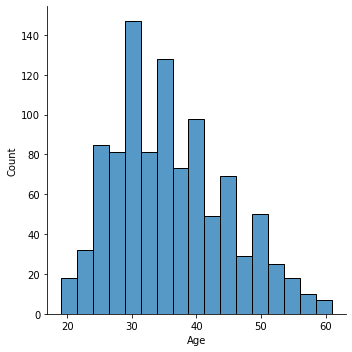

In [3]:
# create a histogram reprsenting age
sns.displot(ad_data['Age'])

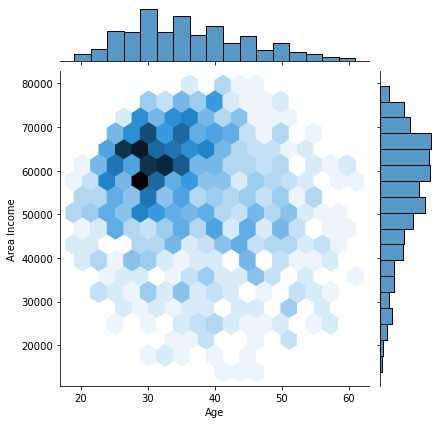

In [4]:
# create a jointplot showing Area Income vs Age
sns.jointplot(x='Age', y='Area Income', data=ad_data, kind='hex')

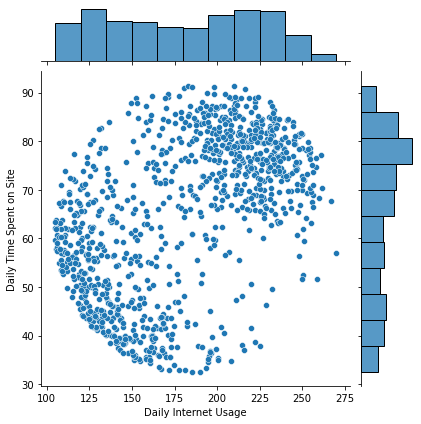

In [5]:
# create a jointplot showing Daily Time Spent on Site vs Daily Internet Usage
sns.jointplot(x='Daily Internet Usage', y='Daily Time Spent on Site', data=ad_data, kind='scatter')

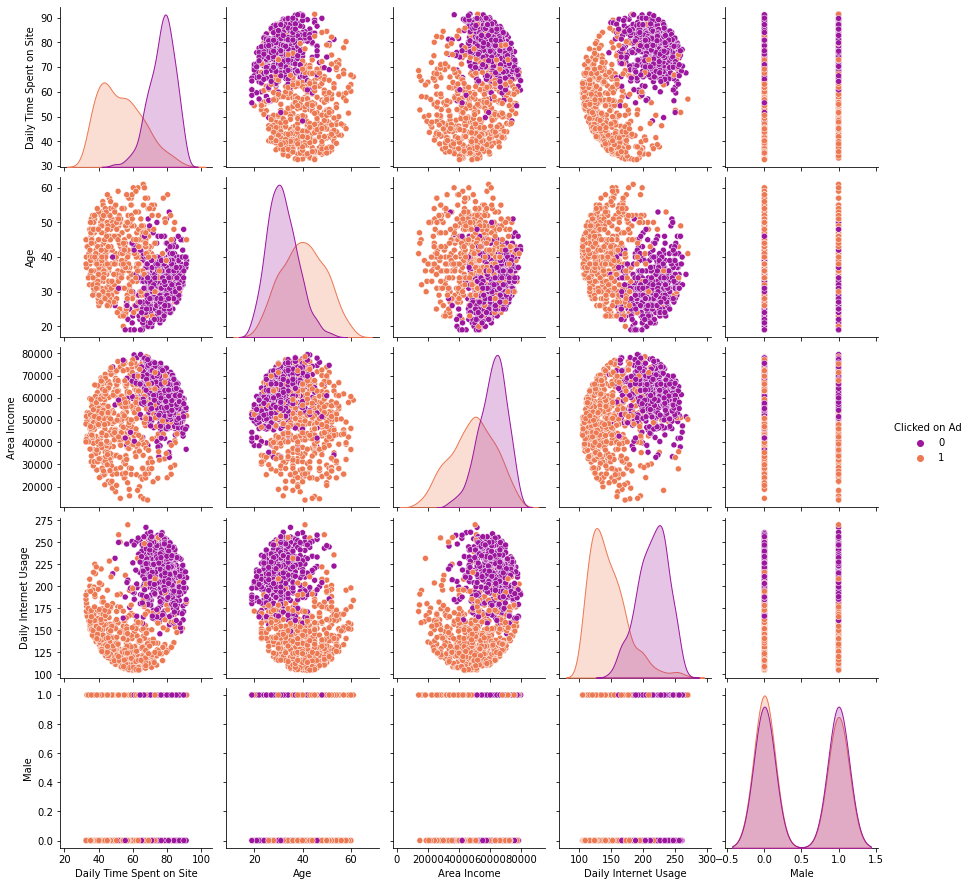

In [6]:
# create a pairplot with the hue defined by Clicked on Ad
sns.pairplot(ad_data, hue='Clicked on Ad', palette='plasma')

### What can we say about these plots?

# *** 
The histogram reveals that from our sample size, we see the largest age group represented to be between 30 and 40 years old. In our first jointplot, we see that the highest income represented has its density distributed between 25 and 35 years old. Our second jointplot demonstrates that while daily internet usage is fairly distributed among our subjects (note the histogram for the x-axis), the scatterplot and particularly the y-axis histogram reveals a strong correlation between those who spend higher amounts of time online and those who spend higher amounts of time on the website. The pairplot shows us all of these facts in one grid of subplots. The hue displaying those who click on an ad or do not is pretty revelatory in this collection, as it provides a summary of users who do or do not click on ads. They are notably concentrated in each of our subplots, and this should help us in our interpretation of the data.
# ***

# Prediction Model

In [7]:
# prepare data for fitting
ad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


<AxesSubplot:xlabel='Clicked on Ad', ylabel='count'>

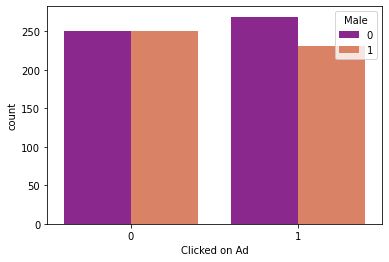

In [8]:
# describes whether those who clicked on ads were mostly or mostly not male
sns.countplot(x='Clicked on Ad',
             hue='Male',
             data=ad_data,
             palette='plasma')

In [9]:
# convert categorical variables to dummy variables & drop string objects from computational analysis
male = pd.get_dummies(ad_data['Male'], drop_first=True)
ad_data.drop(['Male','Ad Topic Line','City','Country','Timestamp'], axis=1, inplace=True)
ad_data = pd.concat([ad_data, male], axis=1)
# convert all values to like data types
for i in ad_data.columns:
    ad_data[i] = ad_data[i].astype(float)
ad_data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad,1
0,68.95,35.0,61833.90,256.09,0.0,0.0
1,80.23,31.0,68441.85,193.77,0.0,1.0
2,69.47,26.0,59785.94,236.50,0.0,0.0
3,74.15,29.0,54806.18,245.89,0.0,1.0
4,68.37,35.0,73889.99,225.58,0.0,0.0


In [10]:
# confirm clean data ready for logistic modelling
ad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   float64
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Clicked on Ad             1000 non-null   float64
 5   1                         1000 non-null   float64
dtypes: float64(6)
memory usage: 47.0 KB


In [11]:
# set dependent and independent variables
X_var = ad_data[['Daily Time Spent on Site','Age','Area Income','Daily Internet Usage',1]]
y_var = ad_data['Clicked on Ad']

In [12]:
# scale the data to prepare for fitting
X_var = StandardScaler().fit(X_var).transform(X_var)

In [13]:
# design the training model
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, 
                                                    test_size=0.33,  # using a 33% test set
                                                    random_state=42)  # using randoms state of 42

In [14]:
# model fitting
lgm = LogisticRegression()
lgm.fit(X_train, y_train)

LogisticRegression()

In [15]:
# predictions
predictions = lgm.predict(X_test)  # P(Y|X)

In [16]:
# evaluate the model using a classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       162
         1.0       0.98      0.96      0.97       168

    accuracy                           0.97       330
   macro avg       0.97      0.97      0.97       330
weighted avg       0.97      0.97      0.97       330



In [17]:
# observe the confusion matrix
confusion_matrix(y_test, predictions)

array([[159,   3],
       [  7, 161]], dtype=int64)

# -------->>> Interpretation

# ***
We tested randomly selected observations of 33% of our 1000-count sample data, or 330 observations. The test results of our training model reveal a True Positive reading of 159 hits (48.18% of all readings), a True Negative reading of 161 hits (48.78% of all readings), and these two readings represent an accuracy of 97% as shown in our F1 score. Our model had a False Positive (Type I error) result of 7 hits (2.12%) and a False Negative (Type II error) result of 3 hits (0.91%). The F1 score is a good indicator of our accuracy by averaging our recall (TP/(TP+FN)) of 159/162 (98.14%) and precision (TP/(TP+FN)) of 159/166 (95.78%). Being that our F1 score is close to 1 (perfection), our model is a decent model of accuracy.
# ***

# Extra Credit

In [18]:
# From the Titanic data in class, Pclass column is actually categorical. Thus it has 1, 2 and 3.
# Apply the pd.get_dummies() function on this column. Model your logistic regression again and
# compare your results to what we did in class.

In [19]:
# import data
titanic_df = pd.read_csv('titanic_data.csv')
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [20]:
# clean data
def generate_age(col):
    Age = col[0]
    Pclass = col[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 40
        elif Pclass == 2:
            return 30
        else:
            return 22
    else:
        return Age
titanic_df['Age'] = titanic_df[['Age','Pclass']].apply(generate_age, axis=1)
titanic_df.drop('Cabin', axis=1, inplace=True)
titanic_df.dropna(inplace=True)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [21]:
# convert categorical variables to dummy variables
sex = pd.get_dummies(titanic_df['Sex'], drop_first=True)
embark = pd.get_dummies(titanic_df['Embarked'], drop_first=True)
pclass = pd.get_dummies(titanic_df['Pclass'], drop_first=True)
titanic_df.drop(['Sex','Embarked','Name','Ticket'], axis=1, inplace=True)
titanic_df = pd.concat([titanic_df, sex, embark, pclass], axis=1)
# convert all values to like data types
for i in titanic_df.columns:
    titanic_df[i] = titanic_df[i].astype(float)
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    float64
 1   Survived     889 non-null    float64
 2   Pclass       889 non-null    float64
 3   Age          889 non-null    float64
 4   SibSp        889 non-null    float64
 5   Parch        889 non-null    float64
 6   Fare         889 non-null    float64
 7   male         889 non-null    float64
 8   Q            889 non-null    float64
 9   S            889 non-null    float64
 10  2            889 non-null    float64
 11  3            889 non-null    float64
dtypes: float64(12)
memory usage: 90.3 KB


In [22]:
# set dependent and independent variables
X_var = titanic_df[['PassengerId','Survived','Pclass','Age','SibSp','Parch','Fare','male','Q','S',2,3]]
y_var = titanic_df['Pclass']
# scale the data to prepare for fitting
X_var = StandardScaler().fit(X_var).transform(X_var)
# design the training model
X_train, X_test, y_train, y_test = train_test_split(titanic_df.drop('Pclass', axis=1),
                                                    titanic_df['Pclass'],
                                                    test_size=0.30,
                                                    random_state=50)
# model fitting
lgm = LogisticRegression()
lgm.fit(X_train, y_train)
# predictions
predictions = lgm.predict(X_test)
# evaluate the model using a classification report
print(classification_report(y_test, predictions))
# observe the confusion matrix
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

         1.0       0.98      0.97      0.98        61
         2.0       1.00      0.96      0.98        51
         3.0       0.97      0.99      0.98       155

    accuracy                           0.98       267
   macro avg       0.99      0.97      0.98       267
weighted avg       0.98      0.98      0.98       267



array([[ 59,   0,   2],
       [  0,  49,   2],
       [  1,   0, 154]], dtype=int64)

In [23]:
# From this exercise, explain how a ML algorithm reacts to a column being continuous or categorical.

# *** 
We now have 3 rows and 3 columns due to our testing for prediction of 3 variables, but our False Negative and False Positive rates are next to nil compared to our in-class model with an F1 score of 81%. We now have a score of 98%.
# ***